In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from IPython.display import Image, display
import seaborn as sns
import numpy as np
import networkx as nx
from itertools import product

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


sns.set()

from src.settings import *
from src.load_embedding import read_embedding, save_embedding, path_to_embedding
from src.load_data import load_email

In [2]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [123]:
methods = [
    'deepwalk', 
#     'n2v_p1_q1', 
    'hist_loss_EMD_ID_ASIM_IGNORE_NEG',
#     'hist_loss_EMD_ID_ASIM_IGNORE_NEG_TF_KDE',
#     'hist_loss_EMD_ID_ASIM_IGNORE_NEG_TF_KDE_BATCH_100',
#     'hist_loss_EMD_ID_ASIM_TF_KDE',
    'hist_loss_EMD_ID_ASIM_TF_KDE_BATCH_100',
    'hist_loss_EMD_ID_ASIM_TF_KDE_BATCH_200',
]

names = []

p_outs = [0.03]
sizes = [300]
p_ins = [0.1]
names += ['SBM_sizes_{}_{}_{}_p_in_{}_p_out_{}_seed_43'.format(size, size, size, p_in, p_out)
         for size, p_in, p_out in product(sizes, p_ins, p_outs)]
# names = ['Email']
# dims = [3, 4, 5, 6, 7, 8, 12, 16, 24, 32, 64, 128]
dims = 8,

Xs = {}
for method, name, dim in product(methods, names, dims):
    try:
        Xs[(method, name, dim)] = read_embedding(path_to_embedding(method, name, dim))
    except Exception as e:
        print('Failed to load {}_{}_d{}.csv'.format(method, name, dim))

Failed to load deepwalk_SBM_sizes_300_300_300_p_in_0.1_p_out_0.03_seed_43_d8.csv


In [113]:
ys = {}
colors = {}
label_count = {
    'Karate': 2,
    'Football': 12,
    'Stars': 5,
    'PolBooks': 3,
    'Protein': 13,
    'Email': 42,
    **{'SBM_sizes_{}_{}_{}_p_in_0.1_p_out_{}_seed_43'.format(size, size, size, p_out): 3 
      for size, p_out in product(sizes, [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
    'SBM_sizes_300_300_300_p_in_0.1_p_out_0.01_seed_43': 3
}

ys['Karate'] = pd.read_csv(
    PATH_TO_KARATE + '/karate.mylabels',
    header=None,
    squeeze=True
)
colors['Karate'] = np.random.rand(2, 3)
ys['Football'] = pd.read_csv(
    PATH_TO_FOOTBALL + '/football_labels.txt',
    header=None,
    squeeze=True
)
colors['Football'] = np.random.rand(12, 3)
ys['Stars'] = pd.read_csv(
    PATH_TO_STARS + '/stars_labels.txt',
    header=None,
    squeeze=True
)
colors['Stars'] = np.random.rand(5, 3)
ys['PolBooks'] = pd.read_csv(
    PATH_TO_POLBOOKS + '/polbooks_labels.txt',
    header=None,
    squeeze=True
)
colors['PolBooks'] = np.random.rand(3, 3)
# ys['Protein'] = pd.read_csv(
#     PATH_TO_PROTEIN + '/protein_new_labels.txt',
#     header=None,
#     squeeze=True
# )
# colors['Protein'] = np.random.rand(13, 3)
ys['Email'] = pd.read_csv(
    PATH_TO_EMAIL + '/email-Eu-core_labels.txt',
    delimiter=' ',
    header=None
)[1]
colors['Email'] = np.random.rand(42, 3)

# t = pd.read_csv(
#     PATH_TO_BLOG_CATALOG + '/group-edges.csv',
#     delimiter=' ',
#     header=None
# )
# print(ys['BlogCatalog'])
# colors['Email'] = np.random.rand(42, 3)
for size in sizes:
    for p_out in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
        colors['SBM_sizes_{}_{}_{}_p_in_0.1_p_out_{}_seed_43'.format(size, size, size, p_out)] = np.random.rand(3, 3)
        ys['SBM_sizes_{}_{}_{}_p_in_0.1_p_out_{}_seed_43'.format(size, size, size, p_out)] = [0] * size + [1] * size + [2] * size

colors['SBM_sizes_300_300_300_p_in_0.1_p_out_0.01_seed_43'] = np.random.rand(3, 3)
ys['SBM_sizes_300_300_300_p_in_0.1_p_out_0.01_seed_43'] = [0] * 300 + [1] * 300 + [2] * 300

SBM_sizes_300_300_300_p_in_0.1_p_out_0.03_seed_43


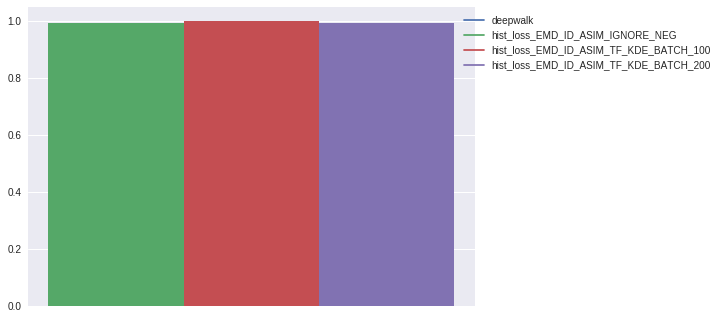

In [124]:
res = {}
for key in Xs:
    name = key[1]
    clus = AgglomerativeClustering(n_clusters=label_count[name])
    y_pred = clus.fit_predict(Xs[key])
    score = normalized_mutual_info_score(ys[name], y_pred)
    res[key] = score

width = 0.1

for name in names:
    print(name)
    for i, method in enumerate(methods):
        plt.bar(
            np.arange(len(
                [i*width for key in Xs if key[0] == method and key[1] == name]
            )) + [i*width for key in Xs if key[0] == method and key[1] == name], 
            [res[key] for key in Xs if key[0] == method and key[1] == name], 
            color='C'+str(i),
            width=width
        )
    methods_legends = [
        mlines.Line2D([], [], color='C'+str(i), label=method)
        for i, method in enumerate(methods)]
    plt.legend(handles=[*methods_legends], loc=1, bbox_to_anchor=(1.55, 1))
    plt.xticks(np.arange(len(dims)), dims)
    plt.show()

Многомерная кластеризация 0.5533639526575447


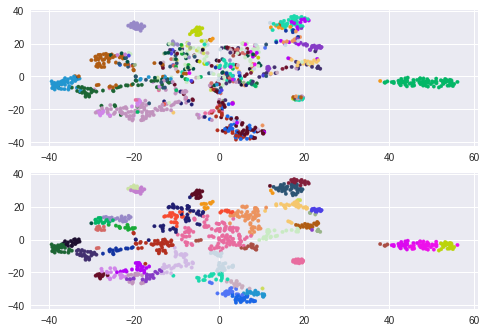

In [77]:
key = ('hist_loss_EMD_ID_ASIM', 'Email', 4)
name, dim = key[1], key[2]
if dim > 2:
    X_pca = PCA(n_components=2).fit_transform(Xs[key])
    X_tsne = TSNE(n_components=2).fit_transform(Xs[key])
X_plt = X_tsne
plt.subplot(211)
plt.scatter(X_plt[:, 0], X_plt[:, 1], c=[colors[name][x] for x in ys[name]], marker='.')
clus = AgglomerativeClustering(n_clusters=label_count[name])
y_pred = clus.fit_predict(Xs[key])
plt.subplot(212)
plt.scatter(X_plt[:, 0], X_plt[:, 1], c=[colors[name][x] for x in y_pred], marker='.')

y_pred = clus.fit_predict(Xs[key])
score = normalized_mutual_info_score(ys[name], y_pred)
print('Многомерная кластеризация', score)

# y_pred = clus.fit_predict(X_pca)
# score = normalized_mutual_info_score(ys[name], y_pred)
# print('Двумерная кластеризация (PCA)', score)


# y_pred = clus.fit_predict(X_tsne)
# score = normalized_mutual_info_score(ys[name], y_pred)
# print('Двумерная кластеризация (TSNE)', score)


plt.show()

In [ ]:
for key in Xs:
    name = key[1]
    clus = AgglomerativeClustering(n_clusters=label_count[name])
    y_pred = clus.fit_predict(Xs[key])
    score = normalized_mutual_info_score(ys[name], y_pred)
    print(key, score)

SBM_sizes_200_200_200_p_in_0.1_p_out_0.03_seed_43


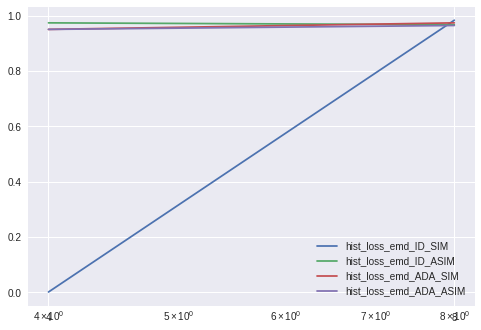

In [84]:
res = {}
for key in Xs:
    name = key[1]
#     clus = AgglomerativeClustering(n_clusters=label_count[name], affinity='cosine', linkage='average')
    clus = AgglomerativeClustering(n_clusters=label_count[name])
#     y_pred = clus.fit_predict(PCA(n_components=3).fit_transform(Xs[key]))
    y_pred = clus.fit_predict(Xs[key])
    score = normalized_mutual_info_score(ys[name], y_pred)
    res[key] = score
    
for name in names:
    print(name)
    for method in methods:
        plt.semilogx(
            [key[2] for key in Xs if key[0] == method and key[1] == name], 
            [res[key] for key in Xs if key[0] == method and key[1] == name], 
            label=method
        )
    plt.legend()
    plt.xticks(dims, dims)
    plt.show()

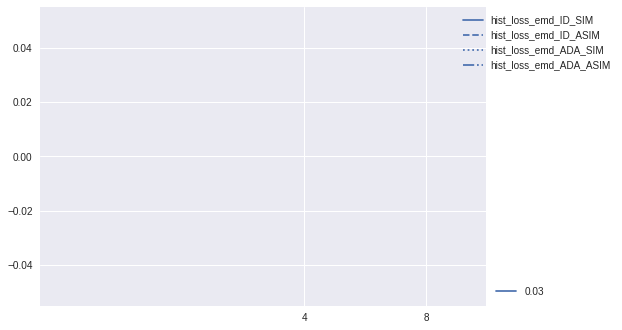

In [60]:
res = {}
for key in Xs:
    name = key[1]
#     clus = AgglomerativeClustering(n_clusters=label_count[name], affinity='cosine', linkage='average')
    clus = AgglomerativeClustering(n_clusters=label_count[name])
#     y_pred = clus.fit_predict(PCA(n_components=3).fit_transform(Xs[key]))
    y_pred = clus.fit_predict(Xs[key])
    score = normalized_mutual_info_score(ys[name], y_pred)
    res[key] = score

# colors = {
#     method: 'C'+str(i) for i, method in enumerate(methods)
# }
   
    
colors = {
    p_out: 'C'+str(i) for i, p_out in enumerate(p_outs)
}

linestyles = dict(zip(methods, ['-', '--', ':', '-.', ]))

for p_out in p_outs:
    name = 'SBM_sizes_100_100_100_p_in_0.1_p_out_{}_seed_43'.format(p_out)
    for method in methods:
        plt.semilogx(
            [key[2] for key in Xs if key[0] == method and key[1] == name], 
            [res[key] for key in Xs if key[0] == method and key[1] == name], 
            colors[p_out],
            ls=linestyles[method],
            label=p_out
        )
#     plt.legend()
p_outs_legends = [
    mlines.Line2D([], [], color=colors[p_out], label=p_out)
    for p_out in p_outs]
methods_legends = [
    mlines.Line2D([], [], ls=linestyles[method], label=method)
    for method in methods]
first_legend = plt.legend(handles=[*p_outs_legends], loc=4, bbox_to_anchor=(1.15, 0))
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[*methods_legends], loc=1, bbox_to_anchor=(1.3, 1))
plt.xticks(dims, dims)
plt.show()

In [127]:
colors

{0.09: 'C8'}

In [ ]:
s = '/home/tsepa/dumps/models/d3/{}_SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43_d4.csv'
A = nx.adjacency_matrix(G).toarray()
Xs = []
poss = []
pos_sampless = []
neg_sampless = []
for i in range(370):
    X = PCA(n_components=2).fit_transform(read_embedding(s.format(i)).values)
    poss.append({i: X[i] for i in range(len(X))})
    
    E_norm = read_embedding(s.format(i)).values
    E_corr = np.dot(E_norm, E_norm.T)
    pos_mask = A
    neg_mask = 1 - pos_mask - np.eye(pos_mask.shape[0])
    pos_samples = E_corr[pos_mask.nonzero()]
    neg_samples = E_corr[neg_mask.nonzero()]
    
    pos_sampless.append(pos_samples)
    neg_sampless.append(neg_samples)


In [ ]:
nx.draw_networkx(
    G, 
    poss[0],
    with_labels=False, 
    node_shape='.', 
    node_size=50, 
    width=0.1, 
    node_color='r'*100 + 'g'*100 + 'b'*100
)
plt.show()


In [ ]:
nx.adjacency_matrix(G).toarray()

In [ ]:
E_norm = read_embedding(s.format(i)).values
E_corr = np.dot(E_norm, E_norm.T)

A = nx.adjacency_matrix(G).toarray()

pos_mask = A
neg_mask = 1 - pos_mask - np.eye(pos_mask.shape[0])

pos_samples = E_corr[pos_mask.nonzero()]
neg_samples = E_corr[neg_mask.nonzero()]

sns.distplot(neg_samples)
sns.distplot(pos_samples)
plt.show()

In [ ]:
nx.draw_networkx(
    G, 
    pos={i: Xs[300][i] for i in range(len(Xs[0]))},
    with_labels=False, 
    node_shape='.', 
    node_size=50, 
    width=0.1, 
    node_color='r'*100 + 'g'*100 + 'b'*100
)


In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
s = '/home/tsepa/dumps/models/nonlinear2/{}_SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43_d7.csv'
A = nx.adjacency_matrix(G).toarray()

poss = []
pos_sampless = []
neg_sampless = []
for i in range(350):
    X = PCA(n_components=2).fit_transform(read_embedding(s.format(i)).values)
    poss.append({i: X[i] for i in range(len(X))})
    
    E_norm = read_embedding(s.format(i)).values
    E_corr = np.dot(E_norm, E_norm.T)
    pos_mask = A
    neg_mask = 1 - pos_mask - np.eye(pos_mask.shape[0])
    pos_samples = E_corr[pos_mask.nonzero()]
    neg_samples = E_corr[neg_mask.nonzero()]
    
    pos_sampless.append(pos_samples)
    neg_sampless.append(neg_samples)

def f(x):
    plt.figure(figsize=(16, 7))
    plt.subplot(121)
    nx.draw_networkx(
        G, 
        pos=poss[x],
        with_labels=False, 
        node_shape='.', 
        node_size=50, 
        width=0.1, 
        node_color='r'*100 + 'g'*100 + 'b'*100
    )
    plt.subplot(122)
    sns.distplot(pos_sampless[x])
    sns.distplot(neg_sampless[x])
    pos_hist = np.histogram(pos_sampless[x], bins=bin_num, normed=True, range=(-1, 1))[0]
    neg_hist = np.histogram(neg_sampless[x], bins=bin_num, normed=True, range=(-1, 1))[0]
    agg = np.cumsum(pos_hist)
    loss = np.dot(agg, neg_hist) * delta ** 2
    print(loss)
    
    y_pred = clus.fit_predict(read_embedding(s.format(x)))
    score = normalized_mutual_info_score(ys['SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43'], y_pred)
    print('Многомерная кластеризация', score)
    plt.show()
interact(f, x=widgets.IntSlider(min=0,max=len(poss) - 1,step=1,value=0));

In [ ]:
bin_num = 64
delta = 2 / (bin_num - 1)
clus = AgglomerativeClustering(n_clusters=label_count[name], affinity='cosine', linkage='average')

@interact(dim=widgets.SelectionSlider(options=[key[2] for key in Xs if key[0] == 'deepwalk']))
def f(dim):
    for key in [('hist_loss', 'SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43', dim),
                ('hist_loss_sim', 'SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43', dim),
                ('deepwalk', 'SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43', dim)]:
        name, dim = key[1], key[2]
        X_tmp = Xs[key].values
        if dim > 2:
            X_pca = PCA(n_components=2).fit_transform(X_tmp)
            X_tsne = TSNE(n_components=2).fit_transform(X_tmp)
            X_vis = X_tsne

        y_pred = clus.fit_predict(Xs[key])
        score = normalized_mutual_info_score(ys[name], y_pred)
        print('Многомерная кластеризация', score)

        y_pred = clus.fit_predict(X_pca)
        score = normalized_mutual_info_score(ys[name], y_pred)
        print('Двумерная кластеризация (PCA)', score)


        y_pred = clus.fit_predict(X_tsne)
        score = normalized_mutual_info_score(ys[name], y_pred)
        print('Двумерная кластеризация (TSNE)', score)
    
        plt.figure(figsize=(10, 3))
        plt.subplot(121)
        nx.draw_networkx(
            G, 
            pos={i: X_vis[i] for i in range(len(X_vis))},
            with_labels=False, 
            node_shape='.', 
            node_size=50, 
            width=0.1, 
            node_color='r'*100 + 'g'*100 + 'b'*100
        )
        plt.subplot(122)
        E = Xs[key].values
        E_norm = E / np.linalg.norm(E, axis=1).reshape((E.shape[0], 1))
        E_corr = np.dot(E_norm, E_norm.T)
        pos_mask = A
        neg_mask = 1 - pos_mask - np.eye(pos_mask.shape[0])
        pos_samples = E_corr[pos_mask.nonzero()]
        neg_samples = E_corr[neg_mask.nonzero()]

        pos_hist = np.histogram(pos_samples, bins=bin_num, normed=True, range=(-1, 1))[0]
        neg_hist = np.histogram(neg_samples, bins=bin_num, normed=True, range=(-1, 1))[0]
        agg = np.cumsum(pos_hist)
        
        loss = np.dot(agg, neg_hist) * delta ** 2
        print(loss)
        sns.distplot(pos_samples)
        sns.distplot(neg_samples)

        plt.show()

In [17]:
key = ('hist_loss', 'SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43', 16)

E = Xs[key].values
E_norm = E / np.linalg.norm(E, axis=1).reshape((E.shape[0], 1))
E_corr = np.dot(E_norm, E_norm.T)
pos_mask = A
neg_mask = 1 - pos_mask - np.eye(pos_mask.shape[0])
pos_samples = E_corr[pos_mask.nonzero()]
neg_samples = E_corr[neg_mask.nonzero()]
sns.distplot(pos_samples)
sns.distplot(neg_samples)


bin_num = 64
pos_bins = np.histogram(pos_samples, bins=bin_num)[1]
pos_hist = np.histogram(pos_samples, bins=bin_num)[0] / pos_samples.shape[0] * (bin_num/2)
neg_bins = np.histogram(neg_samples, bins=bin_num)[1]
neg_hist = np.histogram(neg_samples, bins=bin_num)[0] / neg_samples.shape[0] * (bin_num/2)
agg = np.cumsum(pos_hist)

loss = np.dot(neg_hist, agg)
print(loss)
plt.show()

NameError: name 'A' is not defined

In [20]:
def calc_hist(samples, bin_num=64):
    print(samples)
    print(bin_num)
    delta = 2 / (bin_num - 1)
    print(delta)
    grid_row = np.arange(-1, 1 + delta, delta)
    print(grid_row)
    grid = np.tile(grid_row, (samples.shape[0], 1))
    print(grid)
    samples_grid = np.tile(samples, (grid_row.shape[0], 1)).T
    print(samples_grid)
    dif = np.abs(samples_grid - grid)
    print(dif)
    mask = dif < delta
    print(mask)
    t = np.dot(mask.T, delta - dif).diagonal() / (delta * samples.shape[0] + 0.0001)
    print(t)
    return t

In [101]:
np.set_printoptions(precision=2)
key = ('hist_loss_EMD_ID_ASIM_IGNORE_NEG', 'Email', 16)
bin_num = 64
delta = 2 / (bin_num - 1)

E = Xs[key]
E_norm = E / np.linalg.norm(E, axis=1).reshape((E.shape[0], 1))
E_corr = np.dot(E_norm, E_norm.T)
pos_mask = A
neg_mask = 1 - pos_mask - np.eye(pos_mask.shape[0])
pos_samples = E_corr[pos_mask.nonzero()]
neg_samples = E_corr[neg_mask.nonzero()]

pos_hist = calc_hist(pos_samples, bin_num=bin_num)
neg_hist = calc_hist(neg_samples, bin_num=bin_num)

pos_hist2 = np.histogram(pos_samples, bins=bin_num, normed=True, range=(-1, 1))[0]
neg_hist2 = np.histogram(neg_samples, bins=bin_num, normed=True, range=(-1, 1))[0]

# sns.distplot(pos_samples, bins=bin_num)
# sns.distplot(neg_samples, bins=bin_num)

plt.plot(np.arange(-1, 1+delta, delta), pos_hist)
plt.plot(np.arange(-1, 1+delta, delta), neg_hist)

# plt.plot(np.arange(-1, 1+delta, delta), pos_hist2)
# plt.plot(np.arange(-1, 1+delta, delta), neg_hist2)

agg = np.cumsum(pos_hist / delta)
print(agg)
loss = np.dot(neg_hist / delta, agg)
print(loss * delta ** 2)

plt.show()


NameError: name 'A' is not defined

In [ ]:
from sklearn.neighbors.kde import KernelDensity

In [ ]:
kde = KernelDensity(kernel='linear', bandwidth=0.05).fit(pos_samples.reshape(-1, 1))
rang = np.arange(-1, 1, 0.01)
plt.plot(rang, np.exp(kde.score_samples(rang.reshape(-1, 1))))
kde = KernelDensity(kernel='linear', bandwidth=0.05).fit(neg_samples.reshape(-1, 1))
plt.plot(rang, np.exp(kde.score_samples(rang.reshape(-1, 1))))
plt.show()

In [36]:
PATH_TO_BLOG_CATALOG

'/home/tsepa/GraphEmbeddings/BlogCatalog-dataset/data'

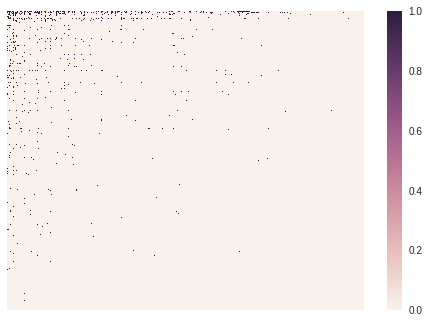

In [39]:
# G = nx.random_partition_graph([100, 100, 100], 0.1, 0.01, 43)

# graph_filename = '{}/email-Eu-core.txt'.format(PATH_TO_EMAIL)
# G = nx.read_edgelist(graph_filename, nodetype=int)
    
G = nx.read_edgelist(
    '{}/edges.csv'.format(PATH_TO_BLOG_CATALOG), nodetype=int
)

A = nx.adj_matrix(G).todense()
D = np.zeros(A.shape)
for i in range(A.shape[0]):
    D[i, i] = np.sum(A[i])
sns.heatmap(A, xticklabels=False, yticklabels=False)
plt.show()

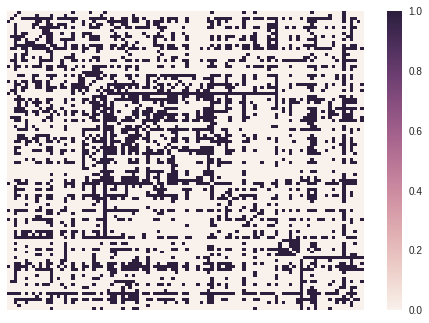

In [44]:
sns.heatmap(A[100:200, 100:200], xticklabels=False, yticklabels=False)
plt.show()

In [ ]:
S = np.dot(np.linalg.inv(D), np.dot(A, A))
sns.heatmap(S - np.eye(S.shape[0]), xticklabels=False, yticklabels=False)
plt.show()

In [ ]:
key = ('hist_loss_sim', 'SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43', 64)

E = Xs[key].values
sns.heatmap(E)
plt.show()

In [ ]:
key = ('deepwalk', 'SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43', 7)

E = read_embedding(path_to_embedding(*key)).values
E_norm = E / np.linalg.norm(E, axis=1).reshape((E.shape[0], 1))
E_corr = np.dot(E_norm, E_norm.T)

G = nx.random_partition_graph([100, 100, 100], 0.1, 0.01, 43)
A = nx.adj_matrix(G).todense()
    
pos_mask = A
neg_mask = 1 - pos_mask - np.eye(pos_mask.shape[0])

pos_samples = E_corr[pos_mask.nonzero()]
neg_samples = E_corr[neg_mask.nonzero()]

sns.distplot(neg_samples)
sns.distplot(pos_samples)
plt.show()

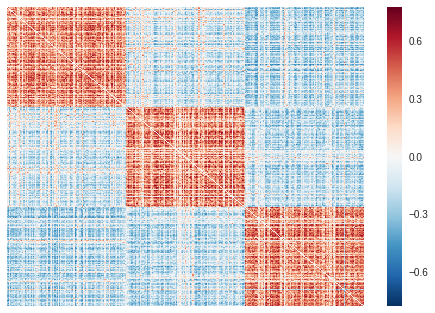

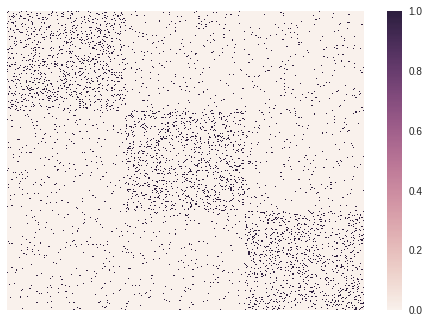

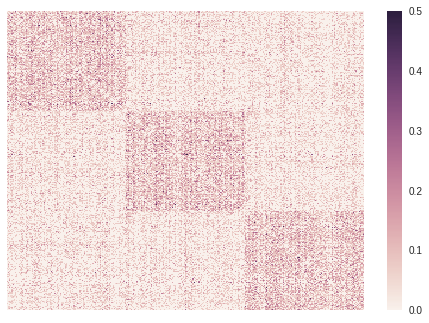

In [89]:
key = ('hist_loss_emd_ID', 'SBM_sizes_100_100_100_p_in_0.1_p_out_0.02_seed_43', 128)

E = read_embedding(path_to_embedding(*key)).values
E_norm = E / np.linalg.norm(E, axis=1).reshape((E.shape[0], 1))
E_corr = np.dot(E_norm, E_norm.T)

G = nx.random_partition_graph([100, 100, 100], 0.1, 0.02, 43)
A = nx.adj_matrix(G).todense()

D = np.zeros(A.shape)
for i in range(A.shape[0]):
    D[i, i] = np.sum(A[i])

S = np.dot(np.linalg.inv(D), np.dot(A, A))

sns.heatmap(E_corr - np.eye(E_corr.shape[0]), xticklabels=False, yticklabels=False)
plt.show()
sns.heatmap(A, xticklabels=False, yticklabels=False)
plt.show()
sns.heatmap(S - np.eye(S.shape[0]), xticklabels=False, yticklabels=False)
plt.show()

In [108]:
bin_num=64
delta = 2 / (bin_num - 1)

key = ('hist_loss_EMD_ID_ASIM', 'Email', 16)
G = load_email().graph
# key = ('hist_loss_sim', 'Email', 64)
# graph_filename = '{}/email-Eu-core.txt'.format(PATH_TO_EMAIL)
# G = nx.read_edgelist(graph_filename, nodetype=int)
A = nx.adj_matrix(G).todense()

D = np.zeros(A.shape)
for i in range(A.shape[0]):
    D[i, i] = np.sum(A[i])

S = np.dot(np.linalg.inv(D), np.dot(A, A))
S = A

E = read_embedding(path_to_embedding(*key))
E_norm = E / np.linalg.norm(E, axis=1).reshape((E.shape[0], 1))
E_corr = np.dot(E_norm, E_norm.T)

@interact_manual(x=widgets.FloatSlider(min=0, max=1, step=0.01))
def f(x):
    pos_mask = (S - np.eye(S.shape[0])) > x
    neg_mask = 1 - pos_mask - np.eye(pos_mask.shape[0])

    pos_samples = E_corr[pos_mask.nonzero()]
    neg_samples = E_corr[neg_mask.nonzero()]

    sns.distplot(neg_samples, bins=bin_num)
    sns.distplot(pos_samples, bins=bin_num)
    plt.show()
    
    pos_hist = np.histogram(pos_samples, bins=bin_num, normed=True, range=(-1, 1))[0]
    neg_hist = np.histogram(neg_samples, bins=bin_num, normed=True, range=(-1, 1))[0]
    agg = np.cumsum(pos_hist)

    loss = np.dot(agg, neg_hist) * delta ** 2
    print(loss)
    
    sns.heatmap(pos_mask, xticklabels=False, yticklabels=False)
    plt.show()
    sns.heatmap(E_corr, xticklabels=False, yticklabels=False)
    plt.show()
    sns.heatmap(np.multiply(E_corr, pos_mask), xticklabels=False, yticklabels=False)
    plt.show()
    sns.heatmap(np.multiply(E_corr, neg_mask), xticklabels=False, yticklabels=False)
    plt.show()

In [ ]:
key = ('hist_loss', 'SBM_sizes_300_300_300_p_in_0.1_p_out_0.01_seed_43', 5)

E = read_embedding(path_to_embedding(*key)).values
E_norm = E / np.linalg.norm(E, axis=1).reshape((E.shape[0], 1))
E_corr = np.dot(E_norm, E_norm.T)

G = nx.random_partition_graph([100, 100, 100], 0.1, 0.01, 43)
A = nx.adj_matrix(G).todense()

@interact_manual(beta=widgets.FloatSlider(1, step=0.01))
def f(beta):
    Katz = np.dot(np.linalg.inv(np.eye(A.shape[0]) - beta * A), beta * A)
    sns.heatmap(Katz)
    plt.show()

In [ ]:
max(np.linalg.eig(A)[0])

In [16]:
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import os

In [13]:
E = read_embedding(path_to_embedding('hist_loss_emd_ID', 'SBM_sizes_100_100_100_p_in_0.1_p_out_0.01_seed_43', 5))

In [14]:
E.shape

(300, 5)

In [17]:
LOG_DIR = '../LOG_DIR'
# Create randomly initialized embedding weights which will be trained.
N = 300 # Number of items (vocab size).
D = 5 # Dimensionality of the embedding.
embedding_var = tf.Variable(tf.random_normal([N,D]), name='word_embedding')

# Format: tensorflow/contrib/tensorboard/plugins/projector/projector_config.proto
config = projector.ProjectorConfig()

# You can add multiple embeddings. Here we add only one.
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(LOG_DIR, 'metadata.tsv')

# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tf.summary.FileWriter(LOG_DIR)

# The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
# read this file during startup.
projector.visualize_embeddings(summary_writer, config)